In [1]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import random

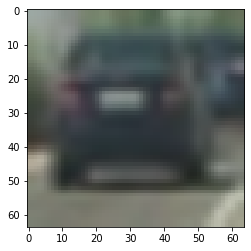

In [2]:
test_img_loc = '/Users/darshpatel/Desktop/ML project/vehicles/GTI_Far/image0000.png'
feature_image = cv2.imread(test_img_loc)
feature_image = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
plt.imshow(feature_image)
plt.show()

In [3]:
color_space = 'YCrCb' 
orient = 9  
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32, 32)
hist_bins = 32   
spatial_feat = True 
hist_feat = True 
hog_feat = True 
y_start_stop = [400, 650]

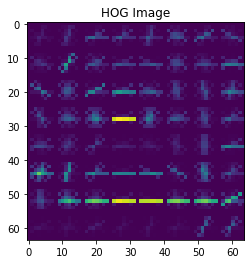

In [4]:

def get_hog_features(img, orient, pix_per_cell, cell_per_block,vis=False, feature_vec=True):
  
    if vis == True:
        features, hog_image = hog(img, orientations=orient,pixels_per_cell=(pix_per_cell, pix_per_cell),cells_per_block=(cell_per_block, cell_per_block),transform_sqrt=True,visualize=vis, feature_vector=feature_vec)
        return features, hog_image
   
    else:      
        features = hog(img, orientations=orient,pixels_per_cell=(pix_per_cell, pix_per_cell),cells_per_block=(cell_per_block, cell_per_block),transform_sqrt=True,visualize=vis, feature_vector=feature_vec)
        return features

feature_image = cv2.imread(test_img_loc)
feature_image = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
hog_features, hog_image = get_hog_features(feature_image[:,:,0], orient,pix_per_cell, cell_per_block, vis=True, feature_vec=True)
plt.imshow(hog_image)
plt.title('HOG Image')
plt.show()

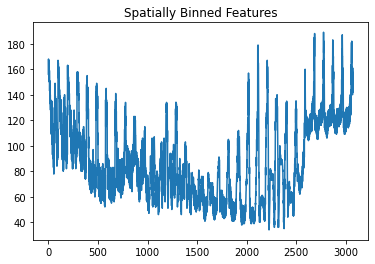

In [5]:

def bin_spatial(img, size=(32, 32)):
    
    features = cv2.resize(img, size).ravel() 
    
    return features


feature_image = cv2.imread(test_img_loc)
feature_image = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
feature_vec = bin_spatial(feature_image, size=spatial_size)
plt.plot(feature_vec)
plt.title('Spatially Binned Features')
plt.show()

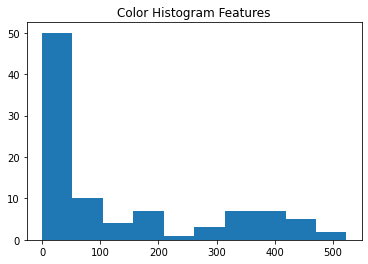

In [6]:


def color_hist(img, nbins=32, bins_range=(0, 256)):
    
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    return hist_features

feature_image = cv2.imread(test_img_loc)
feature_image = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
hist_features = color_hist(feature_image, nbins=hist_bins)
plt.hist(hist_features)
plt.title('Color Histogram Features')
plt.show()

In [7]:

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, hog_features=None):    
    
    img_features = []
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
   
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
       
        img_features.append(spatial_features)
    
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        
        img_features.append(hist_features)
    
    if hog_feat == True:
        if True: 
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))      
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
       
        img_features.append(hog_features)

   
    return np.concatenate(img_features)



def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
  
    features = []
   
    for file in imgs:
        img = cv2.imread(file)
        file_features = single_img_features(img, color_space, spatial_size,
            hist_bins, orient, pix_per_cell, cell_per_block, hog_channel,
            spatial_feat, hist_feat, hog_feat)
        features.append(file_features)
    
    return features

In [8]:
def prepare_images_for_processing(car_img_folders, noncar_img_folders, image_type):
    cars = []
    for folder in car_img_folders:
        cars += glob.glob(folder +'/*.' + image_type)
        
    notcars = []
    for folder in noncar_img_folders:
        notcars += glob.glob(folder +'/*.' + image_type)

    print("Cars len: ", len(cars))
    print("Notcars len: ", len(notcars))

    
    train_size = 8500
    cars = cars[:train_size]
    notcars = notcars[:train_size]
    
    car_features = extract_features(cars, color_space=color_space, 
        spatial_size=spatial_size, hist_bins=hist_bins, 
        orient=orient, pix_per_cell=pix_per_cell, 
        cell_per_block=cell_per_block, 
        hog_channel=hog_channel, spatial_feat=spatial_feat, 
        hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
        spatial_size=spatial_size, hist_bins=hist_bins, 
        orient=orient, pix_per_cell=pix_per_cell, 
        cell_per_block=cell_per_block, 
        hog_channel=hog_channel, spatial_feat=spatial_feat, 
        hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float32)                        
    
    X_scaler = StandardScaler().fit(X)
    
    scaled_X = X_scaler.transform(X)

    
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    return scaled_X, y, X_scaler

In [9]:
car_folders = ['/Users/darshpatel/Desktop/ML project/vehicles/GTI_Far', '/Users/darshpatel/Desktop/ML project/vehicles/GTI_Left', '/Users/darshpatel/Desktop/ML project/vehicles/GTI_MiddleClose', 'train/vehicles/GTI_Right', '/Users/darshpatel/Desktop/ML project/vehicles/KITTI_extracted']
notcar_folders = ['/Users/darshpatel/Desktop/ML project/non-vehicles/Extras', '/Users/darshpatel/Desktop/ML project/non-vehicles/GTI']
scaled_X, y, X_scaler = prepare_images_for_processing(car_folders, notcar_folders, "png")

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

svc = LinearSVC()

t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

t=time.time()

Cars len:  8128
Notcars len:  8968
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
15.1 Seconds to train SVC...
Test Accuracy of SVC =  0.9967


In [ ]:
car_folders_video = ['/Users/darshpatel/Desktop/ML project/vehicle-detection-with-svm-master/car_windows']
notcars_folders_video = ['/Users/darshpatel/Desktop/ML project/vehicle-detection-with-svm-master/noncar_windows']
scaled_X_video, y_video, X_scaler_video = prepare_images_for_processing(car_folders_video,notcars_folders_video,"png")


print('Test Accuracy of SVC on video data = ', round(svc.score(scaled_X_video, y_video), 4))
t=time.time()

Cars len:  0
Notcars len:  0


ValueError: Found array with 0 feature(s) (shape=(2, 0)) while a minimum of 1 is required by StandardScaler.

In [ ]:
def exportFrames():
    vidcap = cv2.VideoCapture('project_video.mp4')
    success,image = vidcap.read()
    count = 0
    success = True
    while success:
        success,image = vidcap.read()
        cv2.imwrite("main_video_frames/frame%d.jpg" % count, image)     # save frame as JPEG file
        count += 1
    print("Complete!")
exportFrames()

In [11]:
def test_image_function(processing_function):
    images = []
    for i in range(6):
        count = random.randint(1,36)
        feature_image = cv2.imread("frames/frame%d.jpg" % count)
        input_img = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
        result_img = processing_function(input_img)
        images.append(result_img)
    f, axarr = plt.subplots(6, 2, figsize=(30, 15))
    for i in range(len(images)):
        cur_img = images[i]
        axarr[i/2,i%2].imshow(cur_img)
    f.subplots_adjust(hspace=0)
    f.show()

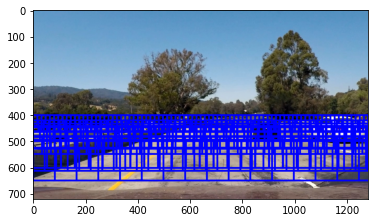

In [20]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None]):
    windows_a = slide_window_helper(img, x_start_stop, y_start_stop, window_size=[128, 128])
    windows_b = slide_window_helper(img, x_start_stop, y_start_stop, window_size=[64, 64])
    windows_c = slide_window_helper(img, x_start_stop, y_start_stop, window_size=[32, 32])
    return windows_a + windows_b + windows_c

def slide_window_helper(img, x_start_stop=[None, None], y_start_stop=[None, None], window_size=[96, 64]):
    window_size_x = window_size[0]
    window_size_y = window_size[1]
    xy_overlap=(0.5, 0.5)
   
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    nx_pix_per_step = np.int32(window_size_x*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int32(window_size_y*(1 - xy_overlap[1]))
   
    nx_windows = np.int32(xspan/nx_pix_per_step) - 2
    ny_windows = np.int32(yspan/ny_pix_per_step) - 2
    
    window_list = []
    
    ys = y_start_stop[0]
    while ys + window_size_y < y_start_stop[1]: 
        xs = x_start_stop[0]
        while xs < x_start_stop[1]:
           
            endx = xs + window_size_x
            endy = ys + window_size_y

            
            window_list.append(((xs, ys), (endx, endy)))

            xs += nx_pix_per_step
        window_size_x = int(window_size_x * 1.3)
        window_size_y = int(window_size_y * 1.3)
        nx_pix_per_step = np.int32(window_size_x*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int32(window_size_y*(1 - xy_overlap[1]))
        ys += ny_pix_per_step


    return window_list


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    
    imcopy = np.copy(img)
    
    for bbox in bboxes:
       
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    
    return imcopy

feature_image = cv2.imread('/Users/darshpatel/Desktop/ML project/vehicle-detection-with-svm-master/test_images/test1.jpg')
feature_image = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
windows = slide_window(feature_image, x_start_stop=[None, None], y_start_stop=y_start_stop)              
window_img = draw_boxes(feature_image, windows, color=(0, 0, 255), thick=6)  
plt.imshow(window_img)
plt.show()

## Search Windows for Features

In [21]:


def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

  
    on_windows = []
    
    count = 0
    image_id = random.randint(0, 2000)
    for window in windows:
        count += 1
        
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
#         cv2.imwrite("frames/window%d%d.jpg" % (image_id, count), test_img)
       
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        test_features = scaler.transform(np.array(features).reshape(1, -1))
       
        prediction = clf.predict(test_features)
        
        if prediction == 1:
            on_windows.append(window)
   
    return on_windows

## Pipeline: Search Image and Label Vehicles

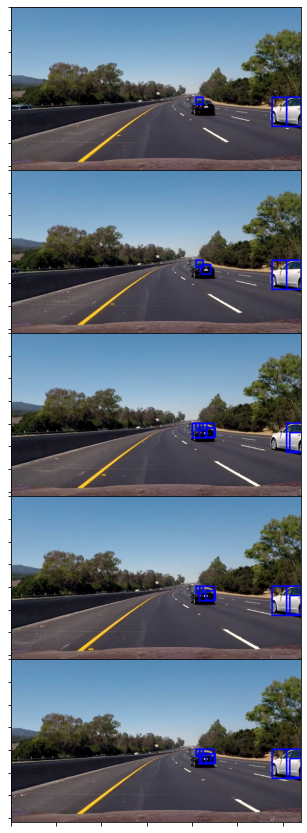

In [22]:
def label_vehicles(image, X_scaler):
    draw_image = np.copy(image)
    draw_image = cv2.cvtColor(draw_image, cv2.COLOR_RGB2BGR)
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop)
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)  
    return window_img

f, axarr = plt.subplots(5, 1, figsize=(30, 15))
startIndex = random.randint(1, 1250)
for i in range(0,5):
    index = i + startIndex
    img = cv2.imread('main_video_frames/frame' + str(index) + '.jpg')
    img_with_label = label_vehicles(img, X_scaler)
    axarr[i].imshow(img_with_label)
plt.setp([a.get_xticklabels() for a in axarr[:]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:]], visible=False)
f.subplots_adjust(hspace=0)
plt.show()

## Use Heat Map to Reduce False Positives and Dupes

/var/folders/kn/lplnssc95ygdfcvn6bl_8bn40000gn/T/ipykernel_63377/3278088483.py:1: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


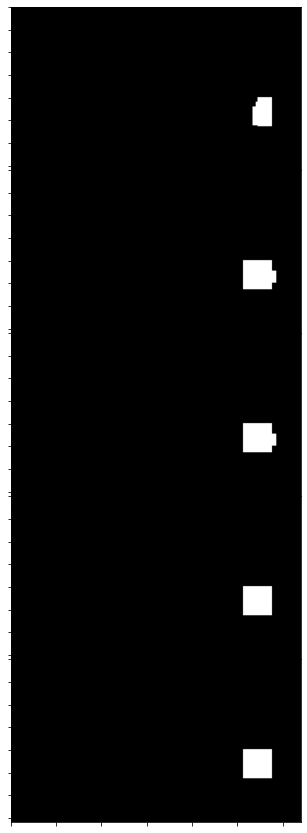

In [28]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    heatmap /= 2
    
    for box in bbox_list:
        
       
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 2

    
    return heatmap

def apply_threshold(heatmap, threshold):
    
    heatmap[heatmap <= threshold] = 0
    
    return heatmap

image = cv2.imread('main_video_frames/frame1.jpg')
heatmap = np.zeros_like(image[:,:,0]).astype(np.float32)
f, axarr = plt.subplots(5, 1, figsize=(30, 15))
labels_list = []
startIndex = random.randint(1, 1250)
for i in range(0,5):
    index = i + startIndex
    image = cv2.imread('main_video_frames/frame' + str(index) + '.jpg')
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop)
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    heatmap = add_heat(heatmap, hot_windows)
    heatmap = apply_threshold(heatmap, 2)
    labels = label(heatmap)
    labels_list.append(labels)
    axarr[i].imshow(labels[0], 'gray')
plt.setp([a.get_xticklabels() for a in axarr[:]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:]], visible=False)
f.subplots_adjust(hspace=0)
plt.show()

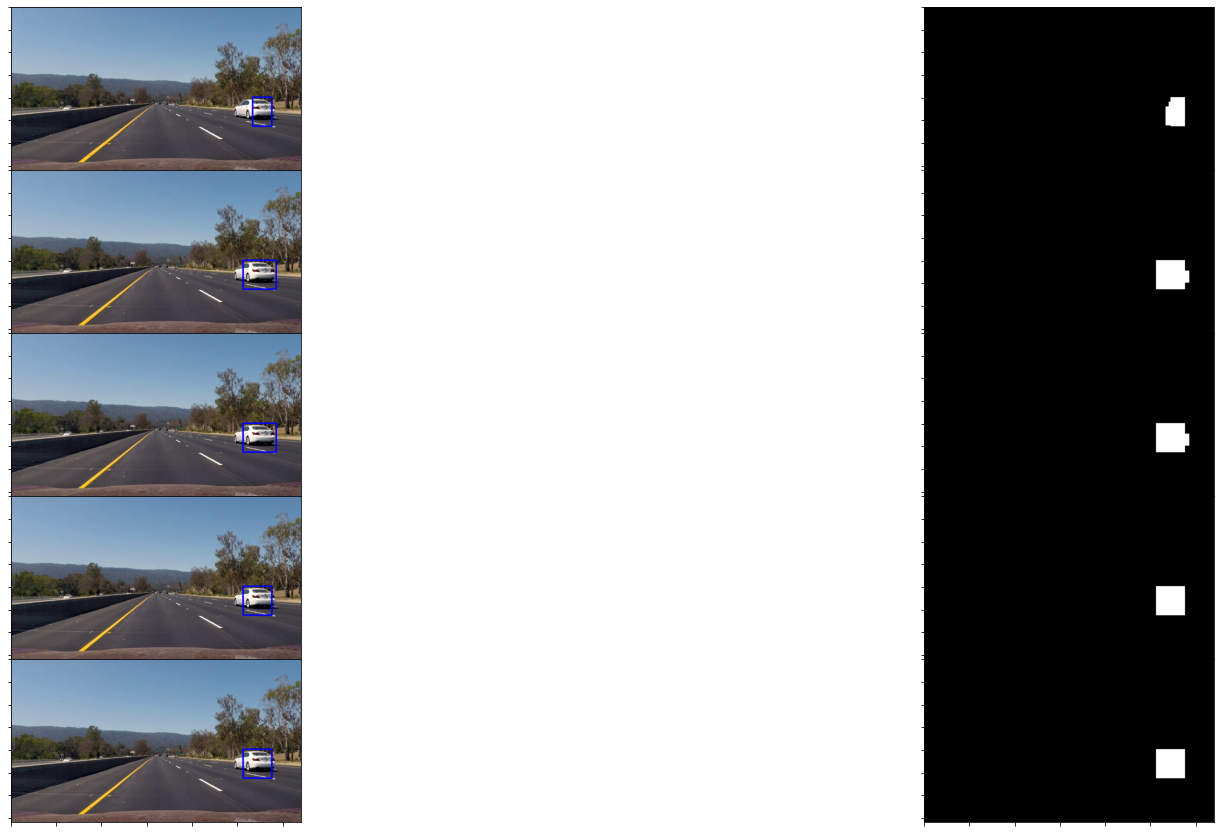

In [29]:
def draw_labeled_bboxes(img, labels):
    
    for car_number in range(1, labels[1]+1):
        
        nonzero = (labels[0] == car_number).nonzero()
        
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
       
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        if((bbox[1][1] - bbox[0][1]) > 30 and (bbox[1][0] - bbox[0][0]) > 30):
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    
    return img


f, axarr = plt.subplots(5, 2, figsize=(30, 15))
for i in range(len(labels_list)):
    labels = labels_list[i]
    draw_image = np.copy(image)
    draw_image = cv2.cvtColor(draw_image, cv2.COLOR_RGB2BGR)
    draw_img = draw_labeled_bboxes(draw_image, labels)
    axarr[i, 1].imshow(labels[0], 'gray')
    axarr[i, 0].imshow(draw_img, 'gray')

plt.setp([a.get_xticklabels() for a in axarr[:, 0]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 0]], visible=False)
plt.setp([a.get_xticklabels() for a in axarr[:, 1]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
f.subplots_adjust(hspace=0)
plt.show()

## Pipeline: Add Heatmap Filtering

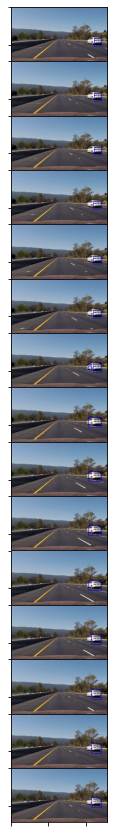

In [33]:
def label_vehicles_with_heat_map(image, convert=True):
    draw_image = np.copy(image)
    if(convert):
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    else:
        draw_image = cv2.cvtColor(draw_image, cv2.COLOR_BGR2RGB)
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop)

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    global heatmap
    heatmap = add_heat(heatmap, hot_windows)
    heatmap = apply_threshold(heatmap, 2)
    labels = label(heatmap)
    
   
    draw_img = draw_labeled_bboxes(draw_image, labels)
    return draw_img

heatmap = np.zeros_like(image[:,:,0]).astype(np.float32)

f, axarr = plt.subplots(15, 1, figsize=(30, 15))
startIndex = random.randint(1, 1250)
for i in range(0,15):
    index = i + startIndex
    img = cv2.imread('main_video_frames/frame' + str(index) + '.jpg')
    window_img = label_vehicles_with_heat_map(img, convert=False)
    axarr[i].imshow(window_img)
plt.setp([a.get_xticklabels() for a in axarr[:]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:]], visible=False)
f.subplots_adjust(hspace=0)
plt.show()

In [32]:

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [39]:
heatmap = np.zeros_like(image[:,:,0]).astype(np.float32)
white_output = 'testvid4_output.mp4'
clip1 = VideoFileClip("testvid5_night.mp4")
white_clip = clip1.fl_image(label_vehicles_with_heat_map) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" cocntrols>
  <source src="{0}">
</video>
""".format(white_output))

                                                                                
t:   4%|█                       | 54/1260 [1:15:37<1:45:04,  5.23s/it, now=None]
                                                                                
t:   6%|█▋                        | 75/1173 [46:32<1:51:47,  6.11s/it, now=None]

Moviepy - Building video testvid4_output.mp4.
Moviepy - Writing video testvid4_output.mp4





t:   0%|                                      | 0/315 [00:00<?, ?it/s, now=None]

t:   1%|▏                             | 2/315 [00:03<09:44,  1.87s/it, now=None]

t:   1%|▎                             | 3/315 [00:07<13:52,  2.67s/it, now=None]

t:   1%|▍                             | 4/315 [00:11<16:13,  3.13s/it, now=None]

t:   2%|▍                             | 5/315 [00:15<17:20,  3.36s/it, now=None]

t:   2%|▌                             | 6/315 [00:18<17:53,  3.47s/it, now=None]

t:   2%|▋                             | 7/315 [00:22<18:15,  3.56s/it, now=None]

t:   3%|▊                             | 8/315 [00:26<18:30,  3.62s/it, now=None]

t:   3%|▊                             | 9/315 [00:30<18:35,  3.65s/it, now=None]

t:   3%|▉                            | 10/315 [00:33<18:39,  3.67s/it, now=None]

t:   3%|█                            | 11/315 [00:37<18:43,  3.70s/it, now=None]

t:   4%|█                            | 12/315 [00:41<18:41,  3.70s/it, now=None]

t:   4%|█▏    

Moviepy - Done !
Moviepy - video ready testvid4_output.mp4
CPU times: user 18min 34s, sys: 4.32 s, total: 18min 38s
Wall time: 18min 45s
